In [53]:
#Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import ast 
import scipy.stats as stats
import math
import seaborn as sns


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm
from sympy import symbols, integrate, lambdify, diff
import scipy.integrate as spi
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans


from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import DBSCAN
### PCA Analysis
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA



### Define Dataset to conduct analysis on: 

In [54]:
time_between_frames = 5
initial_exposure = 60
time_between_exposure = 120
num_frames = 276

#framerange = [(0, 25), (25, 50), (50, 75), (75, 100), (100, 300)]
columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]


In [55]:
#experiment = "combined"
experiment = "M4581_s1"
#experiment = "M4576_s2"
#experiment = "M4581_s7"
#experiment = "M4576_s4"
#experiment = "M4576_s7"
#experiment = "M4581_s4"

#pH pulses
#experiment = "M6543_s1"
#experiment = "M6543_s5"

#constant ph 
#experiment = "M6530_s3"
#experiment = "M6530_s5"
#experiment = "M6530_s7"


---
# Analysis 

### Initialization: includes calculating exposure, bin width, and normalization functions

In [56]:
def calculate_exposure(num_frames, initial_exposure, time_between_exposure, time_between_frames) -> list[int]:

  frames_between_exposures = time_between_exposure/time_between_frames
  first_frame_exposure = initial_exposure/time_between_frames - 1

  print(f"first germinant exposure: {first_frame_exposure}")
  print(f"time between germinant exposures: {frames_between_exposures}")

  exposure_frames = [first_frame_exposure]

  while exposure_frames[-1] + frames_between_exposures < num_frames:
    exposure_frames.append(exposure_frames[-1] + frames_between_exposures)

  return first_frame_exposure, frames_between_exposures, exposure_frames

# function call 
if initial_exposure != None:
  first_frame_exposure, frames_between_exposures, germinant_exposures = calculate_exposure(num_frames, initial_exposure, time_between_exposure, time_between_frames)
  print(f"Germinant exposures: {germinant_exposures}")

  sample_germination_frames = [frame + 2 for frame in germinant_exposures]

first germinant exposure: 11.0
time between germinant exposures: 24.0
Germinant exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0]


Bin Width using (1) Sturges Method (use with small datasets) (2) Scott's Rule normally distributed data (3) Freedman-Diaconis Rule - robust to outliers

In [57]:
def get_bin_width(data, method):  
  if method == "Sturges":
    k = int(np.ceil(np.log2(len(data)) + 1))
    bin_width = (np.max(data) - np.min(data)) / k

  if method == "Scotts":
    bin_width = 3.5 * np.std(data) / (len(data) ** (1/3))

  if method == "Freedman":
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(data) ** (1/3))

  bins = int(np.ceil((data.max() - data.min()) / bin_width))
  return bins

Normalize DataSet: 

In [58]:
def scale_csv_data(file_path: str, columns_to_scale: list[str]):
    data = pd.read_csv(file_path)
    scaler = MinMaxScaler()

    def scale_column(column):
        lists = column.apply(ast.literal_eval)
        flattened = np.concatenate(lists.values)
        scaled_flattened = scaler.fit_transform(flattened.reshape(-1, 1)).flatten()
        scaled_lists = []
        start = 0
        for lst in lists:
            end = start + len(lst)
            scaled_lists.append(scaled_flattened[start:end].tolist())
            start = end
        return [str(lst) for lst in scaled_lists]
    
    for column in columns_to_scale:
        data[column] = scale_column(data[column])

    return data

Datasets:

In [59]:
if experiment == "M6530_s7":
  csv_path = "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6530_s7/Fiji_Processing/PostProcessing/M6530_s7_Model_Data.csv"
  plots_folder= "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6530_s7/Fiji_Analysis/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

if experiment == "M6530_s5":
  csv_path = "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6530_s5/Fiji_Processing/PostProcessing/M6530_s5_Model_Data.csv"
  plots_folder= "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6530_s5/Fiji_Analysis/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

if experiment == "M6530_s3":
  csv_path = "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6530_s3/Fiji_Processing/PostProcessing/M6530_s3_Model_Data.csv"
  plots_folder= "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6530_s3/Fiji_Analysis/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M6543_s5
if experiment == "M6543_s5":
  csv_path = "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6543_s5/Fiji_Processing/PostProcessing/M6543_s5_Model_Data.csv"
  plots_folder= "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6543_s5/Fiji_Analysis/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M6543_s1
if experiment == "M6543_s1":
  csv_path = "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6543_s1/Fiji_Processing/PostProcessing/M6543_s1_Model_Data.csv"
  plots_folder= "/Users/alexandranava/Desktop/Spores/Data/pH_pulses/M6543_s1/Fiji_Analysis/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M4581_s1
if experiment == "M4581_s1":
  csv_path = "/Users/alexandranava/Desktop/Spores/data/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv"
  plots_folder= "/Users/alexandranava/Desktop/Spores/data/M4581_s1/Analysis/V3/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M4576_s2
if experiment == "M4576_s2":
  csv_path = "/Users/alexandranava/Desktop/Spores/Data/M4576_s2/Fiji_Processing/PostProcessing/M4576_s2_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/Data/M4576_s2/Fiji_Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#combined datasets
if experiment == "combined":
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s1andM4576_s2/plots/"
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv"
  M4581_s1_scaleddf  = scale_csv_data(csv_path, columns_to_scale)
  csv_path2 = "/Users/alexandranava/Desktop/Spores/M4576_s2/M4576_s2_Model_Data.csv"
  M4576_s2_scaleddf = scale_csv_data(csv_path2, columns_to_scale)
  df = pd.concat([M4581_s1_scaleddf, M4576_s2_scaleddf], axis=0)
  df.reset_index(drop=True, inplace=True)
  combined = 1

#M4581_s7
if experiment == "M4581_s7":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s7/PostProcess_V4/M4581_s7_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s7/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M4576_s4
if experiment == "M4576_s4":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4576_s4/PostProcess_V2/M4576_s4_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4576_s4/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M4576_s7
if experiment == "M4576_s7":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4576_s7/PostProcess_V2/M4576_s7_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4576_s7/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0
#M4581_s4
if experiment == "M4581_s4":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s4/PostProcess_V4/M4581_s4_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s4/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0
data_folder = plots_folder.replace("Plots", "Data")

## Germination Measurement

Adds Germination Frame to df in "GERMINATION_INDEX" column

In [60]:
def add_germination_index(df):
    GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)
    germination_frames_list = GERMINATION.apply(lambda x: x.index(1))

    df["GERMINATION_INDEX"] = germination_frames_list
    #df["GERMINATION_INDEX"] = df["GERMINATION_INDEX"].astype(float)

add_germination_index(df)

Adds germinant exposures before germination to df in "GERMINANT_EXPOSURES" column

In [61]:
def add_germinant_exposures(df):
  EXPOSURE_COLUMN = [] # {exposure number: spores germinated with that exposure}

  for frame_number in df["GERMINATION_INDEX"]:
    exposure_count = math.floor((frame_number - first_frame_exposure)/frames_between_exposures) + 1
    EXPOSURE_COLUMN.append(exposure_count)
  df["GERMINANT_EXPOSURES"] = EXPOSURE_COLUMN
  if experiment in ["M4581_s7", "M4576_s7"]:
      df = df[df["GERMINANT_EXPOSURES"] != 3]
      df = df.reset_index(drop=True)  # Reindex the dataframe
      df.to_csv(csv_path)
  return df
if initial_exposure!= None:
  df = add_germinant_exposures(df)

Creates a lineplot of population dormancy, as well as a histogram of germination events

optimal bin width: 7
Total Spores: 54

 Statistics by Events:
Frames that events occur: 11
Frames: [13 & 14 & 37 & 38 & 39 & 61 & 62 & 63 & 64 & 86 & 182]
Germination Events: [1 & 4 & 5 & 20 & 1 & 3 & 12 & 2 & 1 & 4 & 1]
Total Percentage: [98 & 91 & 81 & 44 & 43 & 37 & 15 & 11 & 9 & 2 & 0]
Percentage at frame: [7 & 9 & 37 & 2 & 6 & 22 & 4 & 2 & 7 & 2]


<Figure size 300x1000 with 0 Axes>

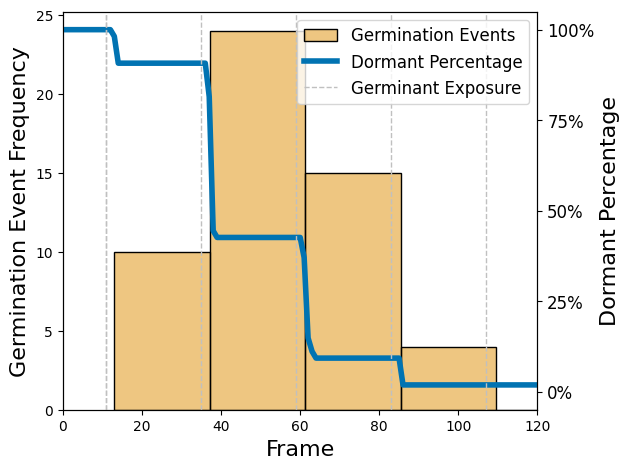

In [190]:
def germination_frequency(plots_folder: str, df, output: int = 1) -> None:

  palette = sns.color_palette("colorblind", n_colors=2)
  germination_frames_list = list(df["GERMINATION_INDEX"])
  last_germ_time = max(germination_frames_list)
  last_germ_time = 120
  frames_shown: int = 250
  ax1 = plt.figure(figsize=(3,10))

  GERMINATION = []
  min_frames = 10000
  for row in df["GERMINATION"].apply(ast.literal_eval):
    if len(row)<min_frames:
      min_frames = len(row)

  for row in df["GERMINATION"].apply(ast.literal_eval):
    GERMINATION.append(row[:min_frames])

  bin_size = get_bin_width(np.array(GERMINATION), "Sturges")
  print(f"optimal bin width: {bin_size}")

  #print times frame germination occurs
  frame_counts = Counter(germination_frames_list)
  sorted_frame_counts = sorted(frame_counts.items())

  germination_events: list[int] = []
  percent_germinated_at_t: list[int] = []
  for frame_number, count in sorted_frame_counts:
      if output == 1:
        germination_events.append(count)
  #histogram plot 
  fig, ax1 = plt.subplots()

  #germinant intervals
  #if initial_exposure!= None:
    #ax1.grid(color='silver', linewidth=1, linestyle = "dashed", which = "both", axis = "x")

  #histogram
  sns.histplot(germination_frames_list, bins = bin_size, label = f"Germination Events", ax = ax1, color = palette[1], alpha = 0.5)
  
  #axis labels 
  ax1.set_xlabel("Frame", fontsize = 16)
  ax1.set_ylabel("Germination Event Frequency", fontsize = 16)

  #x axis limit and ticks
  ax1.set_xlim([0, frames_shown])
 
  #overlaid percentage plot 
  total_spores = sum(count for frame, count in sorted_frame_counts)
  spores_count = total_spores
  frames = [0]
  percents = [100]
  percent_plot = [100]
  frame_dict = dict(sorted_frame_counts)

  total_percent = 100  

  ### by individual frames
  for frame_number in range(1, frames_shown+1):
    if frame_number in frame_dict:
      count = frame_dict[frame_number]
      spores_count -= count
      total_percent = spores_count / total_spores * 100
      t_percent = count/total_spores * 100
      percent_plot.append(total_percent)
      percent_germinated_at_t.append(t_percent)
    percents.append(total_percent)
    frames.append(frame_number)

  #percent plot
  ax2 = ax1.twinx()
  sns.lineplot(x=frames, y=percents, ax = ax2, linewidth = 4, label = "Dormant Percentage", color = palette[0])

  #custom germinant label
  if initial_exposure != None:
    ax2.axvline(x=11, color='silver', label='Germinant Exposure', linewidth = 1, linestyle = "dashed")
    for exposure in germinant_exposures: 
      ax2.axvline(x = exposure, color='silver', linewidth = 1, linestyle = "dashed")

  #percent y axis formatting
  ax2.set_ylabel("Dormant Percentage", fontsize = 16)
  ax2.set_yticks([0, 25, 50, 75, 100])
  ax2.tick_params(axis='y', labelsize=12)
  ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
  
  #legends
  handles1, labels1 = ax1.get_legend_handles_labels()
  handles2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='best', fontsize=12)

  ax1.set_xlim([0, last_germ_time])
  ax2.set_xlim([0, last_germ_time])
  plt.tight_layout()
  plt.savefig(f"{plots_folder}germination_percentage_{bin_size}bins.jpg")
  #plt.clf()
  
  ### Stats
  print(f"Total Spores: {total_spores}")

  ## statistics by frames
  print("\n Statistics by Events:")
  print(f"Frames that events occur: {len(germination_events)}")
  print(f"Frames: {str(list(frame_dict.keys())).replace(',', ' &')}")
  print(f"Germination Events: {str(germination_events).replace(',', ' &')}")
  print(f"Total Percentage: [{' & '.join([f'{elem:.0f}' for elem in percent_plot[1:]])}]")
  print(f"Percentage at frame: [{' & '.join([f'{elem:.0f}' for elem in percent_germinated_at_t[1:]])}]")

  return min_frames
min_frames = germination_frequency(plots_folder, df)

Creates a piechart of germinant exposures until germination

In [63]:
def piechart_germination_exposure(df):
    total_spores = len(df)
    df = df.sort_values(by=['GERMINANT_EXPOSURES'])
    exposures_list = df['GERMINANT_EXPOSURES'].unique()
    value_counts = df['GERMINANT_EXPOSURES'].value_counts()

    #========================GERMINANT EXPOSURE
    ## statistics by germinant exposures
    total_percentage_by_exposure = []
    percentage_at_exposure = []

    total_germinated = 0
    for exposure in exposures_list:
        
        spores_germinated_interval = value_counts[exposure]
        total_germinated += spores_germinated_interval
        total_percentage_by_exposure.append(((total_spores - total_germinated) / total_spores) * 100)

        percentage_at_t = (spores_germinated_interval / total_spores) * 100
        percentage_at_exposure.append(percentage_at_t)

    ### Pie chart by germinant exposures
    labels = [f'$GE_{exposure}$ = {value_counts[exposure] / total_spores * 100 :.2f}%' for exposure in exposures_list]

    plt.clf()
    plt.figure(figsize=(6, 3))
    colors = sns.color_palette('pastel')[0:len(percentage_at_exposure)]

    explode_val = percentage_at_exposure.index(max(percentage_at_exposure))
    explode = [0 for _ in range(len(percentage_at_exposure))]
    explode[explode_val] = 0.1

    plt.pie(percentage_at_exposure, labels=labels, shadow=True, colors=colors, wedgeprops={'edgecolor': 'black'}, startangle=140, explode=explode, pctdistance=1.00, textprops={'fontsize': 16})
    #plt.title("Distribution of Germination Exposures")
    plt.savefig(plots_folder + "piechart_germination_atexposure.jpg")
    plt.clf()

    ## Print stats
    print("\n Statistics by Exposures:")
    print(f"Germinant Exposures: {str(list(exposures_list)).replace(',', ' &')}")
    print(f"Germination Events: {str(list(value_counts)).replace(',', ' &')}")
    print(f"Total Dormancy Percentage: [{' & '.join([f'{elem:.2f}' for elem in total_percentage_by_exposure])}]")
    print(f"Percent Germinated at Exposure: [{' & '.join([f'{elem:.2f}' for elem in percentage_at_exposure])}]")
if initial_exposure!= None:
    piechart_germination_exposure(df)


 Statistics by Exposures:
Germinant Exposures: [1 & 2 & 3 & 4 & 8]
Germination Events: [26 & 18 & 5 & 4 & 1]
Total Dormancy Percentage: [90.74 & 42.59 & 9.26 & 1.85 & 0.00]
Percent Germinated at Exposure: [9.26 & 48.15 & 33.33 & 7.41 & 1.85]


<Figure size 640x480 with 0 Axes>

<Figure size 600x300 with 0 Axes>

## Feature Analysis

Get minimum and maximum global value of a given feature

In [64]:
def get_min_max(df, feature: str) -> int:
    data_max = []
    data_min = []
    data = df[feature].apply(ast.literal_eval) 
    for row in data:
        data_max.append(max(row))
        data_min.append(min(row))
    return [min(data_min), max(data_max)]

minmax_intensity: list[int, int] = get_min_max(df, "INTENSITY")
minmax_area: list[int, int] = get_min_max(df, "AREA")
minmax_minor: list[int, int] = get_min_max(df, "ELLIPSE MINOR")
minmax_major: list[int, int] = get_min_max(df, "ELLIPSE MAJOR")
minmax_perimeter: list[int, int] = get_min_max(df, "PERIMETER")
minmax_circularity: list[int, int] = get_min_max(df, "CIRCULARITY")
minmax_aspectratio: list[int, int] = get_min_max(df, "ELLIPSE ASPECT RATIO")

Adds initial feature value, last feature value before germination, and the difference between these two in "INITIAL_{feature}", "LAST_{feature}" and "DIFF_{feature}" columns

In [65]:
def add_initial_last_measure_feature(df, feature:str):

  FEATURE = df[feature].apply(ast.literal_eval)

  INITIAL_FEATURE_COLUMN = []
  LAST_FEATURE_COLUMN = []
  DIFF_FEATURE_COLUMN = []

  for i in range(len(df)):
    spore_feature = FEATURE[i]
    spore_germination_frame = df.loc[i, "GERMINATION_INDEX"]

    feature_before_germination: list[int] = spore_feature[0: spore_germination_frame]

    initial_feature = np.mean(feature_before_germination[0: 3]) #averaged over first and last frames
    INITIAL_FEATURE_COLUMN.append(initial_feature)
    
    last_feature = np.mean(feature_before_germination[-3: -1])
    LAST_FEATURE_COLUMN.append(last_feature)

    diff_feature = abs(last_feature - initial_feature)
    DIFF_FEATURE_COLUMN.append(diff_feature)

  df[f"INITIAL_{feature}"] = INITIAL_FEATURE_COLUMN
  df[f"LAST_{feature}"] = LAST_FEATURE_COLUMN
  df[f"DIFF_{feature}"] = DIFF_FEATURE_COLUMN


add_initial_last_measure_feature(df, "INTENSITY")
add_initial_last_measure_feature(df, "AREA")
add_initial_last_measure_feature(df, "ELLIPSE MINOR")
add_initial_last_measure_feature(df, "ELLIPSE MAJOR")
add_initial_last_measure_feature(df, "ELLIPSE ASPECT RATIO")
add_initial_last_measure_feature(df, "PERIMETER")
add_initial_last_measure_feature(df, "CIRCULARITY")

### Sample of feature behaviors over time

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

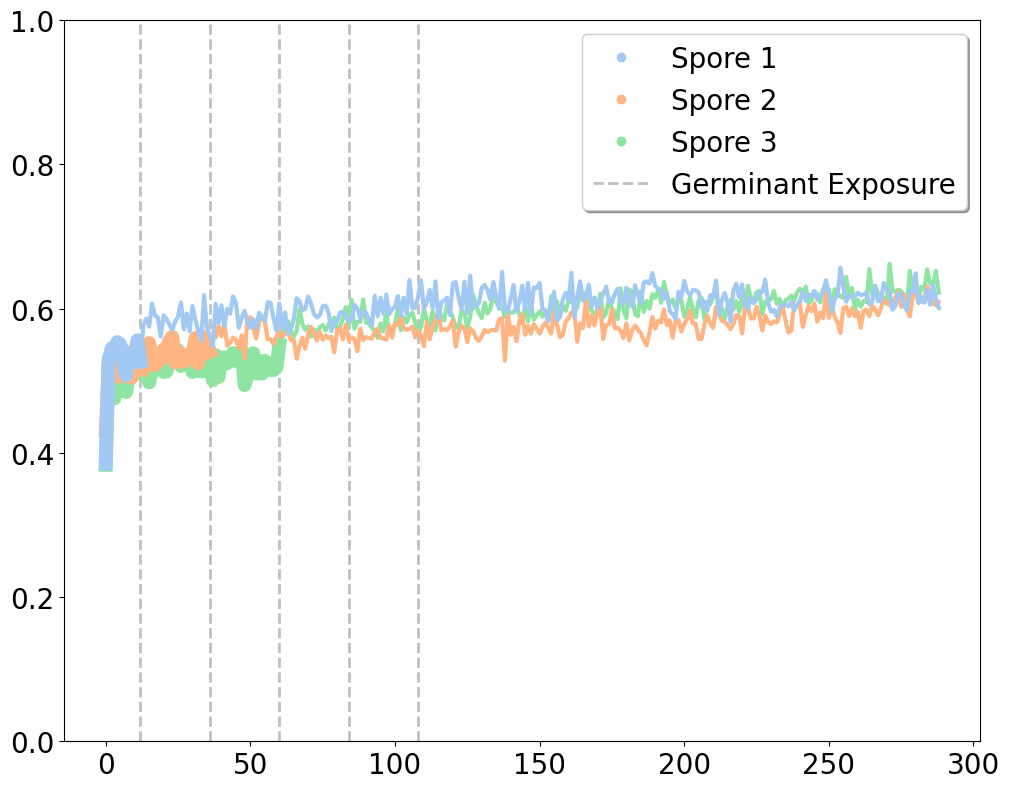

In [66]:
def plot_feature_example(feature_column_title, feature: str, frames: list[int]):
    FEATURE = df[feature_column_title].apply(ast.literal_eval)

    #plot initializing
    plt.clf()
    #palette = sns.color_palette('Spectral', n_colors=len(frames))
    palette = sns.color_palette('pastel')[0:len(frames)]
    custom_handles = []
    spore_labels = []
    plt.figure(figsize=(12,8))

    #germinant intervals
    for frame in frames[0:5]:
      plt.axvline(x = frame - 1, color='silver', linestyle='--', linewidth = 2) 
    custom_handles.append(plt.Line2D([0], [0], color='silver', linestyle='dashed', label="Germinant Exposure", linewidth = 2))

    #---
    for frame in frames[:: -1]: 
      tmp = 0
      for spore_index, feature_row in enumerate(FEATURE):
        germination_frame = df["GERMINATION_INDEX"][spore_index]
        if germination_frame == frame:
          tmp += 1
          if tmp == 1:
            frame_index = frames.index(frame)
            colorline = palette[frame_index % len(palette)]
            #before germination
            sns.lineplot(x=range(germination_frame), y=feature_row[:germination_frame], linewidth=10, color = colorline, label = f"Spore {frame_index + 1}")#, label=f'Germinated at L-alanine Exposure {frames.index(frame) + 1}', )
            #after germination
            sns.lineplot(x = range(germination_frame-1, len(feature_row)), y=feature_row[germination_frame-1:], linestyle = '-', color = colorline, linewidth = 3)
            #legend for spore labels
            custom_handles.append(plt.Line2D([0], [0], color=colorline, lw=4, linestyle='None', marker='o', label=f"Spore {frame_index + 1}"))
            spore_labels.append((f"Spore {frame_index + 1}", colorline))  
            break  

    #axis fonts size
    axis_fontsize = 32
    #plt.xlabel('Frame', fontsize=axis_fontsize) 
    #plt.ylabel(f"{feature}", fontsize=axis_fontsize)  
   
    #axis ticks and limits
    plt.xticks(fontsize = 20)  
    plt.yticks(fontsize = 20)
   # plt.xlim(0, 95)
    plt.ylim(0, 1)

    #legend
    custom_handles = custom_handles[::-1]
    plt.legend(handles=custom_handles, loc='best', shadow = True, fontsize=20)  
    plt.tight_layout(rect=[0, 0, 0.85, 1])  

    plt.savefig(f"{plots_folder}sample_{feature}.jpg")
    plt.clf()

if initial_exposure != None:
  plot_feature_example("INTENSITY", "Electrochemical Potential", sample_germination_frames)
  plot_feature_example("AREA", "Size", sample_germination_frames)
  plot_feature_example("ELLIPSE MINOR", "Ellipse Minor", sample_germination_frames)
  plot_feature_example("ELLIPSE MAJOR", "Ellipse Major", sample_germination_frames)
  plot_feature_example("PERIMETER", "Perimeter", sample_germination_frames)
  plot_feature_example("CIRCULARITY", "Circularity", sample_germination_frames)
  plot_feature_example("ELLIPSE ASPECT RATIO", "Ellipse Aspect Ratio", sample_germination_frames)

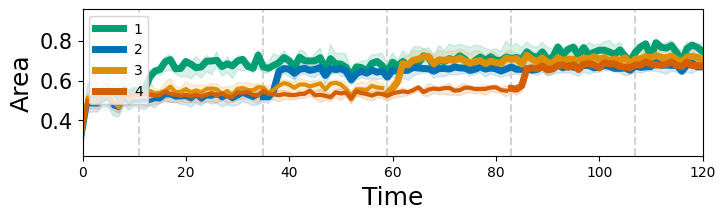

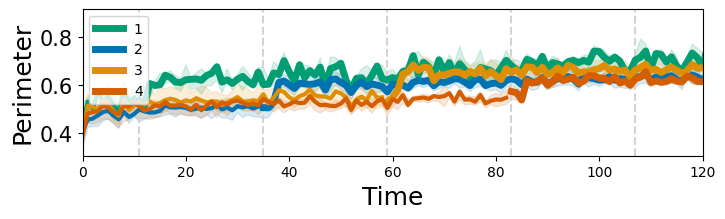

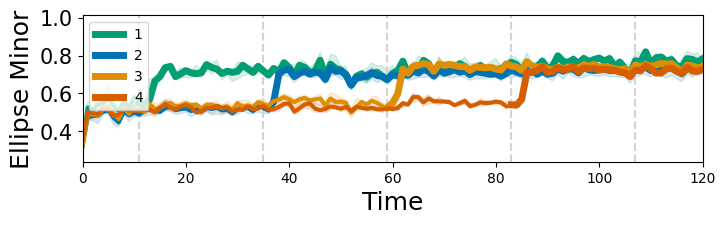

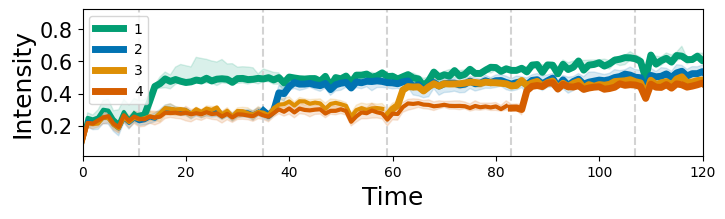

In [195]:
#sns.set_palette("bright")
palette = sns.color_palette("colorblind", n_colors=len(df["GERMINANT_EXPOSURES"].unique()))

# Create a color dictionary
color_dict = dict(zip(df["GERMINANT_EXPOSURES"].unique(), palette))

def timeseries_error_band_by_exposures(df, feature):
    germination_groups = df.groupby("GERMINANT_EXPOSURES")
    i = 0
    plt.figure(figsize=(8,1.9))
    for exp in germinant_exposures:
        plt.axvline(exp, linestyle = "--", color = "lightgrey")
    for exposure_number, group in germination_groups:
        germinant_frame = germinant_exposures[i]
        i += 1
        if len(group) == 1:
            continue
        
        feature_df = pd.DataFrame(group[feature].apply(ast.literal_eval).tolist())
        feature_mean = feature_df.median(axis=0)
        feature_std = feature_df.std(axis=0)
        
        # Generate x values (time points)
        ts = range(len(feature_mean))
        germinant_frame = int(germinant_exposures[i - 1])

        # ts_dormant = ts[:germinant_frame]
        # ts_germinated = ts[germinant_frame:]


        feature_dormant = feature_mean[:germinant_frame]
        ts_germinated = ts[germinant_frame-1:]
        feature_germinated = feature_mean[germinant_frame-1:]
        color = color_dict[exposure_number]

        # Split into dormant and germinated phases
        ts_dormant, ts_germinated = ts[:germinant_frame], ts[germinant_frame:]
        feature_dormant, feature_germinated = feature_mean[:germinant_frame], feature_mean[germinant_frame:]

        # Plot dormant and germinated phases
        color = color_dict[exposure_number]
        sns.lineplot(x=ts_dormant, y=feature_dormant, color=color, linewidth=3)
        sns.lineplot(x=ts_germinated, y=feature_germinated, color=color, linewidth=5, label=f"{exposure_number}")

        lower_bound = feature_df.quantile(0.25, axis=0)  # 10th percentile
        upper_bound = feature_df.quantile(0.75, axis=0)  # 90th percentile

# Fill between these percentiles
        plt.fill_between(ts, lower_bound, upper_bound, alpha=0.15, color=color)
        #plt.plot(ts[:200], lower_bound[:200], color=color, alpha = 0.2)
        #plt.plot(ts[:200], upper_bound[:200], color=color, alpha = 0.2)


        #plt.title(rf"{feature.title()}", fontsize = 24)
        #plt.xticks(fontsize = 14)
        #plt.yticks([0.5, 0.5, 1], fontsize = 16)
        #plt.ylim(-.05, 1.05)
        plt.xlim([0, 120])
        plt.xlabel("Time", fontsize = 18)
        plt.yticks(fontsize = 15)
        plt.ylabel(rf"{feature.title()}", fontsize = 18)
        plt.legend(fontsize=10, loc="upper left")        #plt.legend(title="Germinant Exposures", fontsize = 16, loc = "upper left")


# Example usage
timeseries_error_band_by_exposures(df, "AREA")
timeseries_error_band_by_exposures(df, "PERIMETER")
timeseries_error_band_by_exposures(df, "ELLIPSE MINOR")
timeseries_error_band_by_exposures(df, "INTENSITY")



### PENDING: Feature Trends

In [ ]:
def feature_trends(df, feature: str, exposures: list[int]):
    germination_groups = df.groupby("GERMINANT_EXPOSURES")
    for germination_frame, group in germination_groups:
        FEATURE = group[feature].apply(ast.literal_eval)
        
        mean_features = []
        
        # Calculate the maximum length of the time series to pad shorter series
        max_length = max(FEATURE.apply(len))
        
        # Create an array to accumulate the sums
        sum_features = np.zeros(max_length)
        count_features = np.zeros(max_length)
        
        for row in FEATURE:
            row_len = len(row)
            sum_features[:row_len] += row
            count_features[:row_len] += 1
            plt.scatter(range(row_len), row, s = .5, color = "lightblue")
        
        mean_features = sum_features / count_features
        
        # Plot the mean feature trend
        plt.plot(range(0, germination_frame), mean_features[:germination_frame])
        plt.plot(range(germination_frame-1, len(mean_features)), mean_features[germination_frame -1:])
        
        plt.xlabel('Frame')
        plt.ylabel(f'Normalized {feature.lower()}')
        plt.title(f'{feature[0] + feature[1:].lower()} for Exposure {germination_frame}')
        plt.legend()
        plt.show()
        plt.clf()

#feature_trends(df, "INTENSITY", germinant_exposures)
        


Spores Germinated at Exposure 1 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.32', '0.51', '0.51', '0.54', '0.61', '0.65', '0.67', '0.74', '0.73', '0.78', '0.72', '0.81', '0.15']
Differences Between Means: ['0.18', '-0.00', '0.03', '0.07', '0.04', '0.02', '0.07', '-0.02', '0.05', '-0.06', '0.10', '-0.66']

Spores Germinated at Exposure 2 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.23', '0.28', '0.46', '0.46', '0.50', '0.56', '0.60', '0.66', '0.64', '0.70', '0.66', '0.75', '0.10']
Differences Between Means: ['0.05', '0.18', '-0.00', '0.05', '0.05', '0.04', '0.06', '-0.01', '0.06', '-0.04', '0.09', '-0.65']

Spores Germinated at Exposure 3 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.24', '0.28', '0.27', '0.46', '0.49', '0.53', '0.57', '0.63', '0.63', '0.67', '0.65', '0.72',

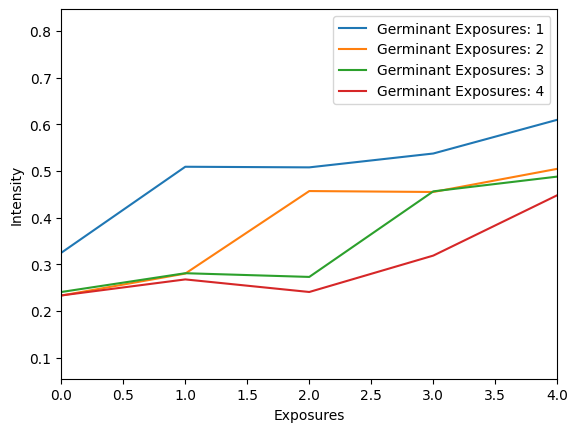


Spores Germinated at Exposure 1 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.56', '0.66', '0.64', '0.70', '0.71', '0.72', '0.75', '0.74', '0.76', '0.76', '0.78', '0.75', '0.37']
Differences Between Means: ['0.11', '-0.03', '0.06', '0.01', '0.01', '0.03', '-0.01', '0.03', '-0.01', '0.02', '-0.03', '-0.38']

Spores Germinated at Exposure 2 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.48', '0.50', '0.59', '0.64', '0.64', '0.65', '0.67', '0.67', '0.69', '0.69', '0.71', '0.70', '0.31']
Differences Between Means: ['0.02', '0.09', '0.05', '0.01', '0.01', '0.02', '0.00', '0.02', '0.00', '0.02', '-0.02', '-0.39']

Spores Germinated at Exposure 3 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.54', '0.56', '0.54', '0.70', '0.70', '0.71', '0.73', '0.72', '0.74', '0.75', '0.77', '0.75', 

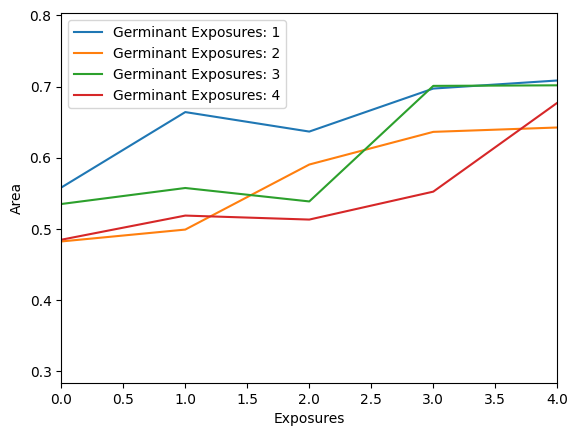

<Figure size 640x480 with 0 Axes>

In [ ]:
def feature_trends_stats(df, feature: str, germinant_exposures: list[int]):
  germinant_exposures.append(0)

  germination_groups = df.groupby("GERMINANT_EXPOSURES")
  num_max_exposures = 0

  #iterate through each group that germinates at a different exposure
  for exposure_number, exposure_group in germination_groups:
    if len(exposure_group) == 1:
      continue

    #get maximum number of exposure to germinate 
    num_max_exposures = max(num_max_exposures, exposure_number)


    #array rows denote each spore value at different exposures, columns are different spores 
    array = np.zeros((len(germinant_exposures), len(exposure_group))) #row is germinant exposure, column is spore index value

    #appends spore values to arrays 
    for spore_index in range(len(exposure_group)):
        spore_feature: list[int] = exposure_group[feature].apply(ast.literal_eval).iloc[spore_index]
        for frame_index in range(min_frames):
          if frame_index in germinant_exposures:
            row_index = germinant_exposures.index(frame_index)
            array[row_index, spore_index] = spore_feature[frame_index]

    row_means = np.mean(array, axis=1)
    diff_between_means = [row_means[i] - row_means[i - 1] for i in range(1, len(row_means))]

    row_medians = np.median(array, axis = 1)
    diff_between_medians = [row_medians[i] - row_medians[i - 1] for i in range(1, len(row_medians))]

    # Truncate to 2 decimal places
    row_means_rounded = [f"{x:.2f}" for x in row_means]
    diff_between_means_rounded = [f"{x:.2f}" for x in diff_between_means]



    # Truncate to 2 decimal places
    row_medians_rounded = [f"{x:.2f}" for x in row_medians]
    diff_between_medians_rounded = [f"{x:.2f}" for x in diff_between_medians]

    print(f"\nSpores Germinated at Exposure {exposure_number} Stats:")
    print(f"Exposures: {germinant_exposures}")
    print(f"Row Means: {row_means_rounded}")
    print(f"Differences Between Means: {diff_between_means_rounded}")

    #print(f"Row Medians: {row_medians_rounded}")
    #print(f"Differences Between Medians: {diff_between_medians_rounded}")
    
    plt.plot(range(len(row_means)), row_means, label = f"Germinant Exposures: {exposure_number}")

  plt.xlim(0, num_max_exposures)
  plt.xlabel("Exposures")
  plt.ylabel(f"{feature[0] + feature[1:].lower()}")
  plt.legend()
  plt.show()
  plt.clf()

if initial_exposure != None:
  feature_trends_stats(df, "INTENSITY", germinant_exposures[:])
  feature_trends_stats(df, "AREA", germinant_exposures[:])

### Heatmap of Spore Features over the Population

In [ ]:
def plot_feature_allspores(df, feature_column_title, feature: str):
  plt.clf()
  exp_length = np.min(len(df["GERMINATION"][:]))
     

  df = df.sort_values(by='GERMINATION_INDEX')
  FEATURE_pre = df[feature_column_title].apply(ast.literal_eval).tolist()

  FEATURE = []
  for spore_row in FEATURE_pre:
     FEATURE.append(spore_row[:exp_length])
     
  Z = np.array(FEATURE)


  ax = sns.heatmap(data = Z, cbar_kws={"label": f"{feature.replace('_', ' ').title()}"})#, cmap=plt.cm.viridis)
  ax.figure.axes[-1].yaxis.label.set_size(14)

  if initial_exposure != None:
    for frame in germinant_exposures:
        plt.axvline(x=frame, color='grey', linestyle="dotted", linewidth = 2)
  print([tmp for tmp in germinant_exposures if tmp < exp_length])
  plt.xticks([tmp for tmp in germinant_exposures if tmp < exp_length], [int(tmp) for tmp in germinant_exposures if tmp < exp_length])
  plt.xticks(rotation = None)

  plt.xlabel("Frame", fontsize = 18)
  plt.ylabel("Spore Index", fontsize = 18)
  plt.title(f"{feature.replace('_', ' ').title()}", fontsize = 24)
  plt.savefig(f"{plots_folder + feature}.jpg")
  plt.clf()

plot_feature_allspores(df, "INTENSITY", "Intensity")
plot_feature_allspores(df, "AREA", "Area")
plot_feature_allspores(df, "ELLIPSE MINOR", "Minor")
#plot_feature_allspores(df, "ELLIPSE MAJOR", "Major")
plot_feature_allspores(df, "PERIMETER", "Perimeter")
#plot_feature_allspores(df, "CIRCULARITY", "Circularity")
#plot_feature_allspores(df, "ELLIPSE ASPECT RATIO", "AspectRatio")
#plot_feature_allspores(df, "GERMINATION", "Germination")

[11.0, 35.0]
[11.0, 35.0]
[11.0, 35.0]
[11.0, 35.0]


<Figure size 640x480 with 0 Axes>

## Feature Relationships

### Heatmap showing Pearson Correlation Coefficient between Physiological Features

<Figure size 640x480 with 0 Axes>

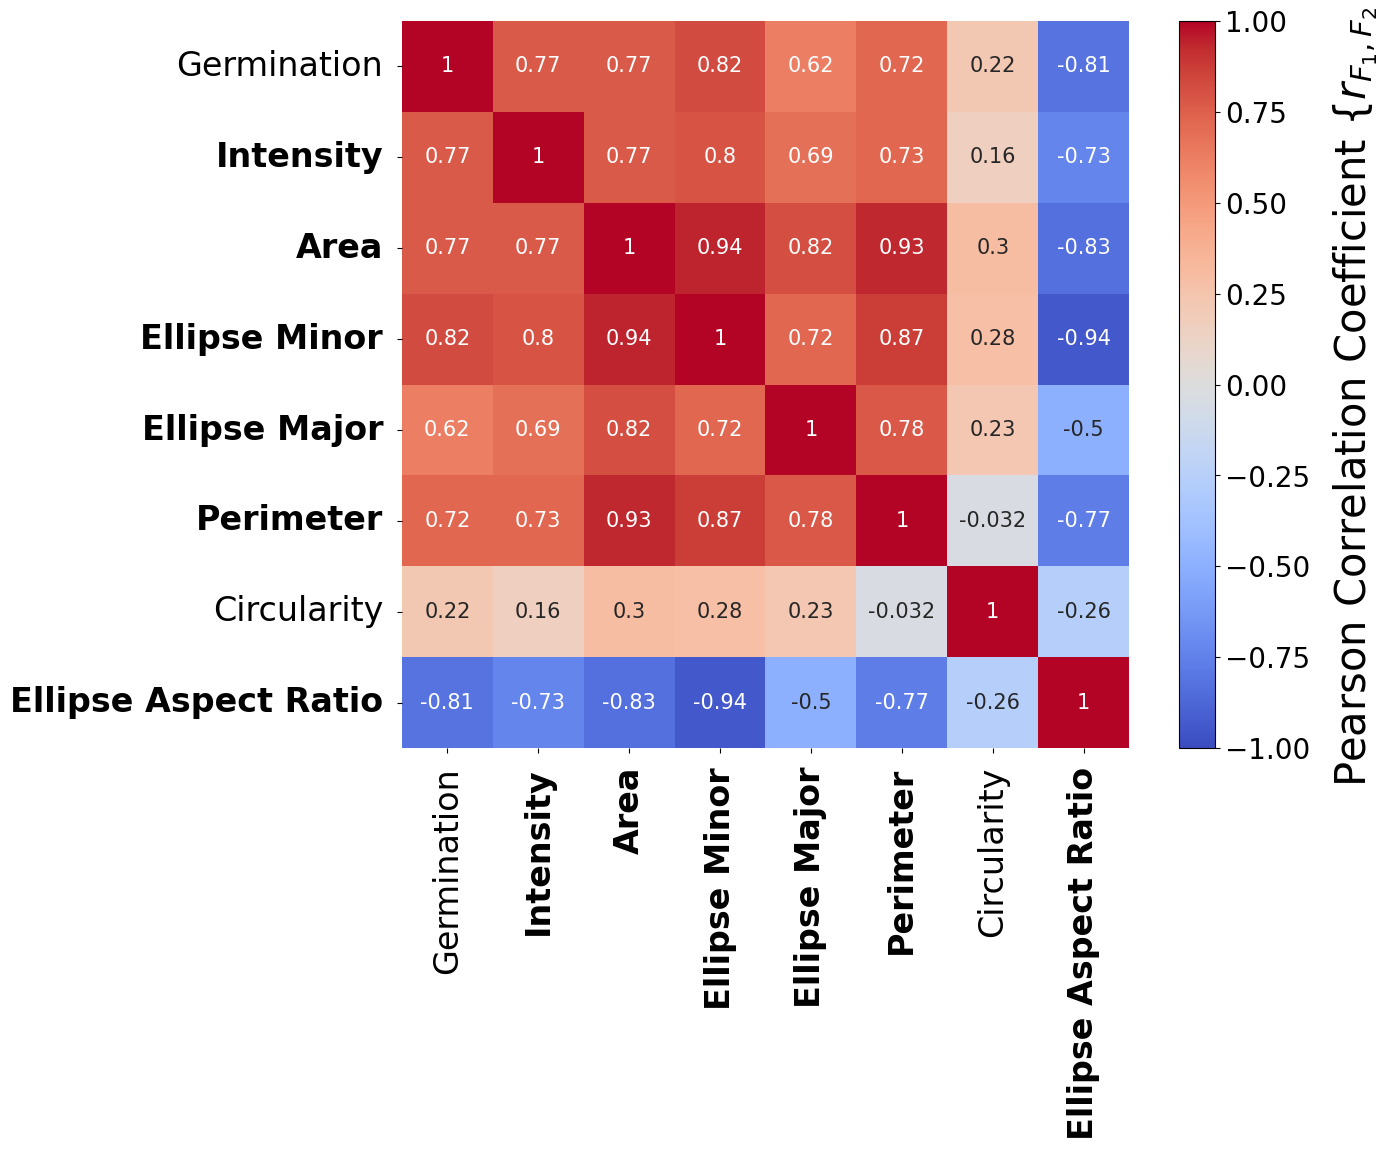

In [ ]:
def feature_heatmap(df, features_list, plot_title, custom_labels, bold_labels):
  '''takes in df in format where each row denotes a spore and each column is a feature and each cell is feature over time in a list'''
  plt.clf()

  correlation_matrices = []

  for spore_index in range(len(df)):
    spore_features = []
    for feature in features_list:
      spore_feature = ast.literal_eval(df.loc[spore_index, feature])
      spore_features.append(spore_feature)
    spore_df = pd.DataFrame(spore_features).T
    spore_df.columns = features_list

    spore_feature_correlation = spore_df.corr()

    correlation_matrices.append(spore_feature_correlation)
  
  avg_correlation_matrix = np.mean(correlation_matrices, axis=0)
  avg_correlation_df = pd.DataFrame(avg_correlation_matrix, index=features_list, columns=features_list)
  avg_correlation_df.rename(columns=custom_labels, index=custom_labels, inplace=True)

  # Plot the heatmap for the average correlation matrix
  plt.figure(figsize = ((14,13)))
  ax = sns.heatmap(avg_correlation_df, annot=True, vmin=-1, vmax=1, cmap="coolwarm", 
                   xticklabels=True, yticklabels=True, annot_kws={"size": 15}, #numbers in heatmap
                   cbar_kws={'label': "$r_{F_1, F_2}$"}, cbar = False)

  ax.set_aspect('equal')

  # Customize tick labels
  tick_font_size = 24

  for tick in ax.get_xticklabels():
      if bold_labels and tick.get_text() in bold_labels:
          tick.set_weight('bold')
      tick.set_fontsize(tick_font_size) #labels size
  
  for tick in ax.get_yticklabels():
      if bold_labels and tick.get_text() in bold_labels:
          tick.set_weight('bold')
      tick.set_fontsize(tick_font_size)
  plt.yticks(rotation=0) 
  plt.xticks(rotation=90) 


      
  #padding between labels and heatmap
  ax.tick_params(axis='x', pad=10)
  ax.tick_params(axis='y', pad=10)

  #colorbar with the same height as the heatmap
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cbar = plt.colorbar(ax.collections[0], cax=cax)

  # Customize colorbar label size
  cbar.ax.tick_params(labelsize=20)
  cbar.ax.yaxis.label.set_size(30)
  cbar.ax.yaxis.label.set_text("Pearson Correlation Coefficient {$r_{F_1, F_2}$}")
  cbar.ax.yaxis.labelpad = 15

  #save
  plt.tight_layout()
  plt.savefig(f"{plots_folder + plot_title}.jpg")


  # feature heatmap call 

heatmap_labels = {
  'GERMINATION': 'Germination',
  'INTENSITY': 'Intensity',
  "AREA": "Area",
  "ELLIPSE MINOR": "Ellipse Minor",
  "ELLIPSE MAJOR": "Ellipse Major",
  "PERIMETER": "Perimeter",
  "CIRCULARITY": "Circularity",
  "GERMINANT EXPOSURE": "Germinant Exposure",
  "ELLIPSE ASPECT RATIO": "Ellipse Aspect Ratio"
  }
features = ["GERMINATION", "INTENSITY", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR", "PERIMETER", "CIRCULARITY", "ELLIPSE ASPECT RATIO"]
bold_labels = ["Intensity", "Area", "Ellipse Minor", "Ellipse Major", "Perimeter", "Ellipse Aspect Ratio"]
feature_heatmap(df, features, "Feature Correlations over Time", heatmap_labels, bold_labels)